# Map Transformations Scratch
Default form of coordinates is cartesian on unit sphere. Units in/out of non-plotting functions is radians. Degrees for plotting functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import importlib as il
import map_proj as mp

%matplotlib notebook

DEG2RAD = np.pi / 180
RAD2DEG = 180 / np.pi
M2KM = 1000
RE = 6378 * M2KM

In [2]:
fname = "./data/vector/custom_coastline.npy"
coords_load = np.load(fname) # input coords are spherical, degrees

<IPython.core.display.Javascript object>


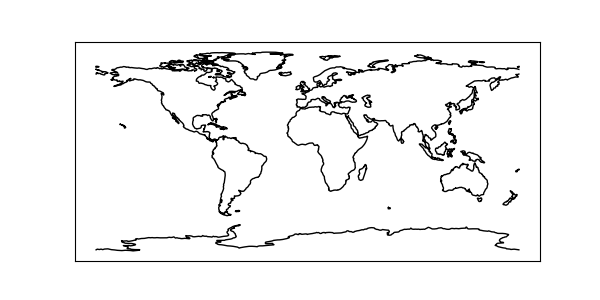

In [3]:
ax = mp.plot_line_map(coords_load)

## Default Coords

In [5]:
coords = mp.spherical_to_cartesian(coords_load * DEG2RAD)
grid = mp.make_grid([-np.pi/2, -np.pi/3, -np.pi/6, 0, np.pi/6, np.pi/3, np.pi/2],
                           [-np.pi, -2*np.pi/3, -np.pi/3, 0, np.pi/3, 2*np.pi/3, np.pi])

## Equirectangular
Equidistant, any point to either pole

<IPython.core.display.Javascript object>


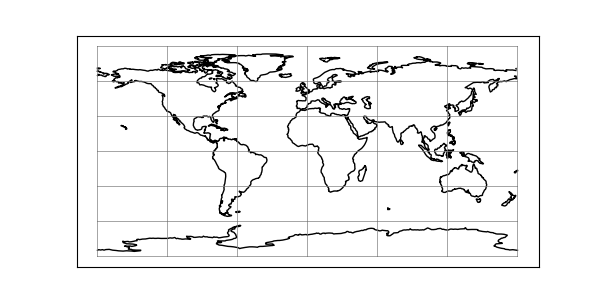

In [5]:
center_lon = 0*DEG2RAD
center_lat = 0*DEG2RAD
heading = 0*DEG2RAD

coords2 = mp.transform_spherical(coords, center_lon, center_lat, heading)
grid2 = mp.transform_spherical(grid, center_lon, center_lat, heading)
breaks = mp.calc_line_breaks(coords2)
breaks_grid = mp.calc_line_breaks(grid2)


ax = mp.plot_line_map(coords2, breaks, figsize=(6,3))
ax = mp.plot_line_map(grid2, breaks_grid, ax=ax, color="grey", linewidth=0.5)

<IPython.core.display.Javascript object>


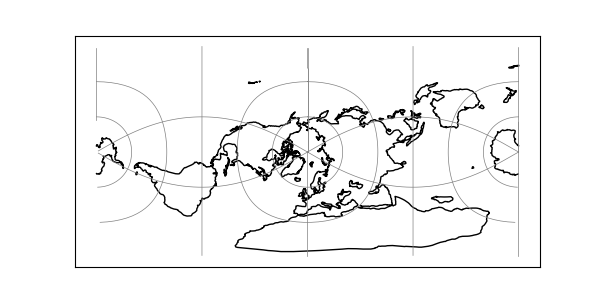

In [6]:
center_lon = 90*DEG2RAD
center_lat = 90*DEG2RAD
heading = 90*DEG2RAD

coords2 = mp.transform_spherical(coords, center_lon, center_lat, heading)
grid2 = mp.transform_spherical(grid, center_lon, center_lat, heading)
breaks = mp.calc_line_breaks(coords2)
breaks_grid = mp.calc_line_breaks(grid2)


ax = mp.plot_line_map(coords2, breaks, figsize=(6,3))
ax = mp.plot_line_map(grid2, breaks_grid, ax=ax, color="grey", linewidth=0.5)

## Central Cylindrical

<IPython.core.display.Javascript object>


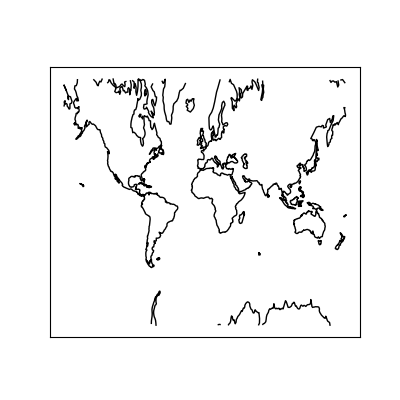

In [7]:
truncate_lat = 70 * DEG2RAD

coords_spherical = mp.cartesian_to_spherical(coords)
coords_cylindrical = np.zeros(shape=coords_spherical.shape)
coords_cylindrical[:,0] = coords_spherical[:,0]
coords_cylindrical[:,1] = np.tan(coords_spherical[:,1])
coords_cylindrical[np.abs(coords_spherical[:,1])>truncate_lat,:] = np.nan

breaks = mp.calc_line_breaks(coords_cylindrical, 1)
ax = mp.plot_line_map(coords_cylindrical, breaks, figsize=(4,4))

## Mercator
Conformal (angles preserved, no local distortion)

<IPython.core.display.Javascript object>


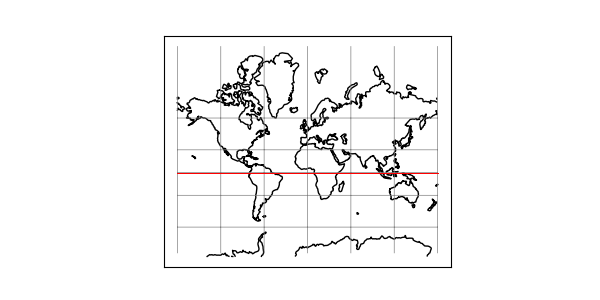

In [8]:
truncate_north = 85 * DEG2RAD
truncate_south = -75 * DEG2RAD

ref_lat = 0 * DEG2RAD

axis_lon = 0 * DEG2RAD
axis_lat = 90 * DEG2RAD
axis_roll = 0 * DEG2RAD

coords_mercator, ref_parallels = mp.transform_mercator(coords, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll, True)
grid_mercator = mp.transform_mercator(grid, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll)

breaks = mp.calc_line_breaks(coords_mercator)
breaks_grid = mp.calc_line_breaks(grid_mercator)

ax = mp.plot_line_map(coords_mercator, breaks, figsize=(6,3))
ax = mp.plot_line_map(grid_mercator, breaks_grid, ax=ax, color="grey", linewidth=0.5)
ax = mp.plot_line_map(ref_parallels, ax=ax, color="r", linewidth=0.5)

<IPython.core.display.Javascript object>


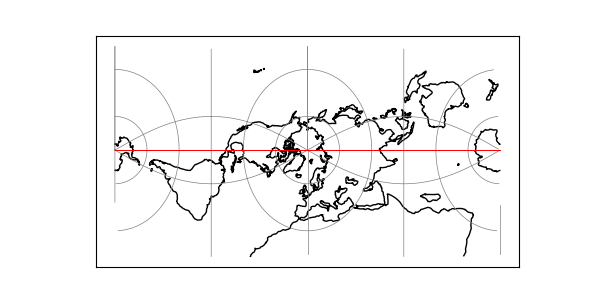

In [9]:
truncate_north = 70 * DEG2RAD
truncate_south = -70 * DEG2RAD

ref_lat = 0 * DEG2RAD

axis_lon = 180 * DEG2RAD
axis_lat = 0 * DEG2RAD
axis_roll = 180 * DEG2RAD

coords_mercator, ref_parallels = mp.transform_mercator(coords, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll, True)
grid_mercator = mp.transform_mercator(grid, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll)

breaks = mp.calc_line_breaks(coords_mercator)
breaks_grid = mp.calc_line_breaks(grid_mercator)

ax = mp.plot_line_map(coords_mercator, breaks, figsize=(6,3))
ax = mp.plot_line_map(grid_mercator, breaks_grid, ax=ax, color="grey", linewidth=0.5)
ax = mp.plot_line_map(ref_parallels, ax=ax, color="r", linewidth=0.5)

Two lat/lon points define oblique mercator axis

<IPython.core.display.Javascript object>


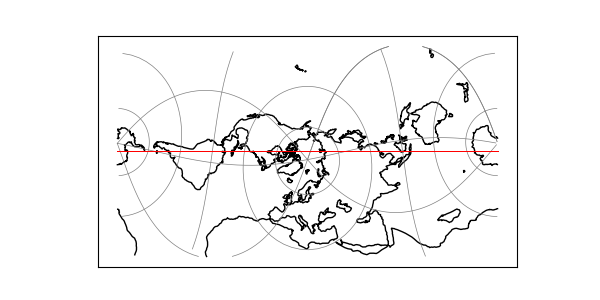

In [10]:
lat1 = 40*DEG2RAD
lon1 = -77*DEG2RAD

lat2 = 40 * DEG2RAD
lon2 = 116*DEG2RAD

axis_roll = 180 * DEG2RAD

truncate_north = 70 * DEG2RAD
truncate_south = -70 * DEG2RAD

ref_lat = 0 * DEG2RAD

r1 = np.array([np.cos(lat1)*np.cos(lon1), np.cos(lat1)*np.sin(lon1), np.sin(lat1)])
r2 = np.array([np.cos(lat2)*np.cos(lon2), np.cos(lat2)*np.sin(lon2), np.sin(lat2)])

axrot = np.cross(r1, r2)
axrot = axrot / np.linalg.norm(axrot)

axis_lat = np.arcsin(axrot[2])
axis_lon = np.arctan2(axrot[1], axrot[0])

coords_mercator, ref_parallels = mp.transform_mercator(coords, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll, True)
grid_mercator = mp.transform_mercator(grid, truncate_north, truncate_south, ref_lat, axis_lon, axis_lat, axis_roll)

breaks = mp.calc_line_breaks(coords_mercator)
breaks_grid = mp.calc_line_breaks(grid_mercator)

ax = mp.plot_line_map(coords_mercator, breaks, figsize=(6,3))
ax = mp.plot_line_map(grid_mercator, breaks_grid, ax=ax, color="grey", linewidth=0.5)
ax = mp.plot_line_map(ref_parallels, ax=ax, color="r", linewidth=0.5)

## Lambert Equal Area
Equal area, no distortion along equator

<IPython.core.display.Javascript object>


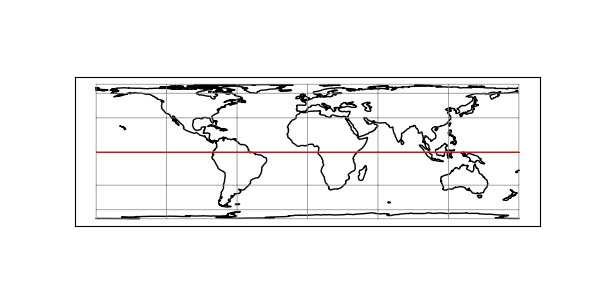

In [11]:
truncate_north = 90 * DEG2RAD
truncate_south = -90 * DEG2RAD

ref_lat = 0

coords_lambert, ref_parallels = mp.transform_lambert_cylindrical(coords, truncate_north, truncate_south, ref_lat, True)
grid_lambert = mp.transform_lambert_cylindrical(grid, truncate_north, truncate_south, ref_lat)

breaks = mp.calc_line_breaks(coords_lambert)
breaks_grid = mp.calc_line_breaks(grid_lambert)

ax = mp.plot_line_map(coords_lambert, breaks, figsize=(6,3))
ax = mp.plot_line_map(grid_lambert, breaks_grid, ax=ax, color="grey", linewidth=0.5)
ax = mp.plot_line_map(ref_parallels, ax=ax, color="r", linewidth=0.5)

## Gall-Peters
Equal area, no distortion at 45 parallels

<IPython.core.display.Javascript object>


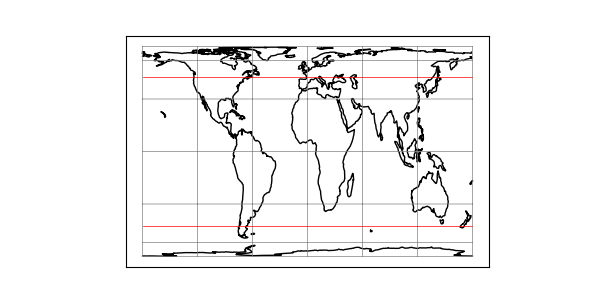

In [12]:
truncate_north = 90 * DEG2RAD
truncate_south = -90 * DEG2RAD

ref_lat = 45 * DEG2RAD

coords_lambert, ref_parallels = mp.transform_lambert_cylindrical(coords, truncate_north, truncate_south, ref_lat, True)
grid_lambert = mp.transform_lambert_cylindrical(grid, truncate_north, truncate_south, ref_lat)

breaks = mp.calc_line_breaks(coords_lambert)
breaks_grid = mp.calc_line_breaks(grid_lambert)

ax = mp.plot_line_map(coords_lambert, breaks, figsize=(6,3))
ax = mp.plot_line_map(grid_lambert, breaks_grid, ax=ax, color="grey", linewidth=0.5)
ax = mp.plot_line_map(ref_parallels, ax=ax, color="r", linewidth=0.5)

## Sinusoidal
Equal area

<IPython.core.display.Javascript object>


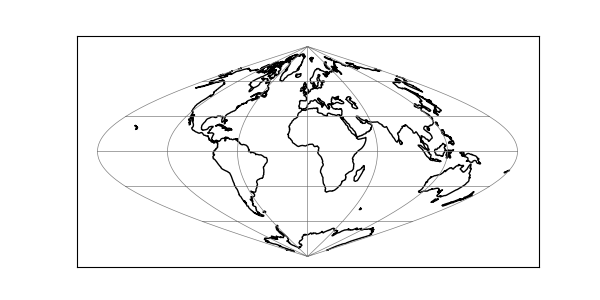

In [13]:
center_lon = 0*DEG2RAD
center_lat = 0*DEG2RAD
heading = 0*DEG2RAD

coords_sin = mp.transform_sinusoidal(coords, center_lon, center_lat, heading)
grid_sin = mp.transform_sinusoidal(grid, center_lon, center_lat, heading)

breaks = mp.calc_line_breaks(coords_sin)
breaks_grid = mp.calc_line_breaks(grid_sin)

ax = mp.plot_line_map(coords_sin, breaks, figsize=(6,3))
ax = mp.plot_line_map(grid_sin, breaks_grid, ax=ax, color="grey", linewidth=0.5)

## Interrupted Sinusoidal

<IPython.core.display.Javascript object>


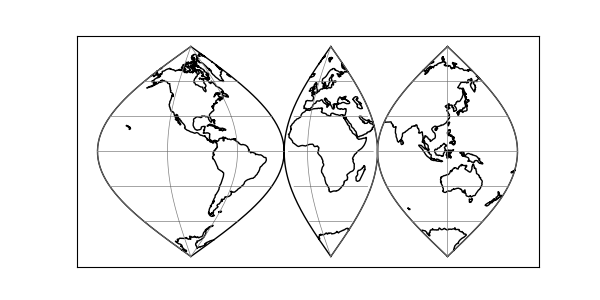

In [14]:
center_lon = 0*DEG2RAD
center_lat = 0*DEG2RAD
heading = 0*DEG2RAD

# interrupts = [-100*DEG2RAD, 40*DEG2RAD, 80*DEG2RAD]
# style = "center"

interrupts = [-20*DEG2RAD, 60*DEG2RAD]
style = "break"

coords_sin_int = mp.transform_sinusoidal_interrupted(coords, interrupts, center_lon, center_lat, heading, style, True)
grid_sin_int = mp.transform_sinusoidal_interrupted(grid, interrupts, center_lon, center_lat, heading, style, False)

breaks = mp.calc_line_breaks(coords_sin)
breaks_grid = mp.calc_line_breaks(grid_sin)

ax = mp.plot_line_map(coords_sin_int, breaks, figsize=(6,3))
ax = mp.plot_line_map(grid_sin_int, breaks_grid, ax=ax, color="grey", linewidth=0.5)

## Mollweide
Equal area

/home/peter/Projects/mapping/venv/lib/python3.6/site-packages/scipy/optimize/zeros.py:451: RuntimeWarning: some derivatives were zero
  warnings.warn(msg, RuntimeWarning)


<IPython.core.display.Javascript object>


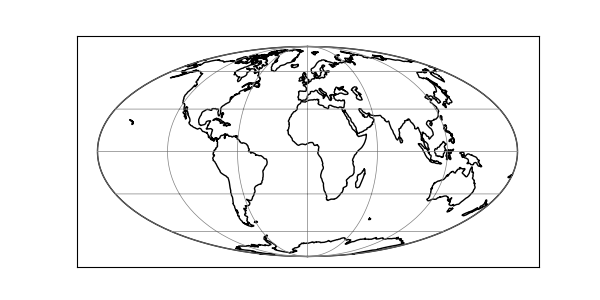

In [15]:
center_lon = 0*DEG2RAD
center_lat = 0*DEG2RAD
heading = 0*DEG2RAD

coords_mollweide = mp.transform_mollweide(coords, center_lon, center_lat, heading, True)
grid_mollweide = mp.transform_mollweide(grid, center_lon, center_lat, heading, False)

breaks = mp.calc_line_breaks(coords_mollweide)
breaks_grid = mp.calc_line_breaks(grid_mollweide)

ax = mp.plot_line_map(coords_mollweide, breaks, figsize=(6,3))
ax = mp.plot_line_map(grid_mollweide, breaks_grid, ax=ax, color="grey", linewidth=0.5)

## Equidistant Conic
Distance to pole or edge is accurate

## Albers
Conic equal area

## Lambert Conic
Conformal

## Gnomonic
Great circles as lines

<IPython.core.display.Javascript object>


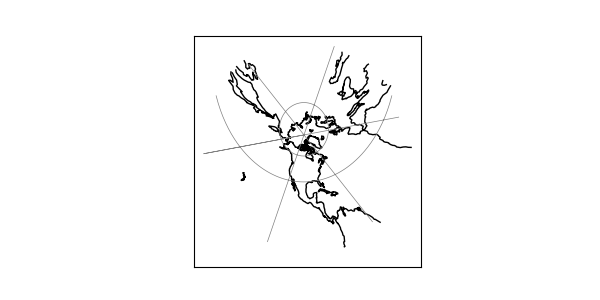

In [6]:
# center lat/lon is tangent point of plane
tangent_lon = -100*DEG2RAD
tangent_lat = 70*DEG2RAD
heading = 0*DEG2RAD

truncate_lat = 70 * DEG2RAD # must be < 90 deg

coords_gnomonic = mp.transform_gnomonic(coords, truncate_lat, tangent_lon, tangent_lat, heading, True)
grid_gnomonic = mp.transform_gnomonic(grid, truncate_lat, tangent_lon, tangent_lat, heading, False)

ax = mp.plot_line_map(coords_gnomonic, figsize=(6,3))
ax = mp.plot_line_map(grid_gnomonic, ax=ax, color="grey", linewidth=0.5)

## Azimuthal Equidistant

## Two Point Equidistant
All distances to two points are correct

## Far Side Perspective
Stereographic `alt=0`

<IPython.core.display.Javascript object>


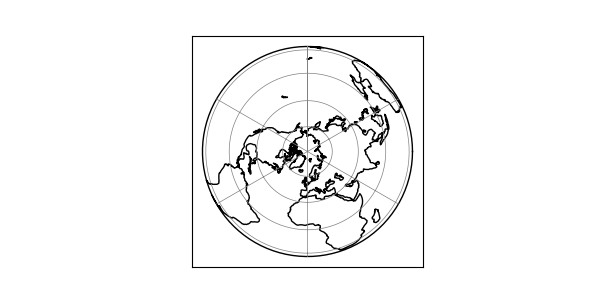

In [140]:
alt = 0.5*RE
center_lon = 0*DEG2RAD
center_lat = 90*DEG2RAD
heading = 0*DEG2RAD
truncate_ang = 0.37*np.pi

coords_far = mp.transform_perspective_far_side(coords, center_lat, center_lon, alt, heading, truncate_ang, True)
grid_near = mp.transform_perspective_far_side(grid, center_lat, center_lon, alt, heading, truncate_ang, False)

ax = mp.plot_line_map(coords_far, figsize=(6,3))
ax = mp.plot_line_map(grid_near, ax=ax, color="grey", linewidth=0.5)

## Near Side Perspective

<IPython.core.display.Javascript object>


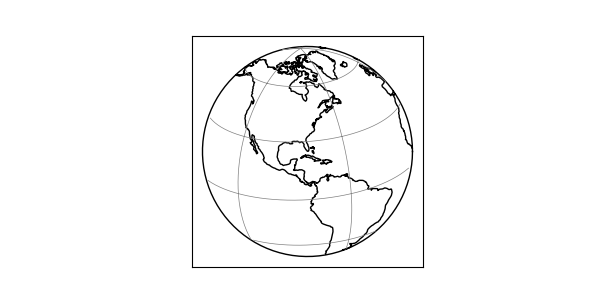

In [8]:
alt = 10000*M2KM
center_lon = -81*DEG2RAD
center_lat = 25*DEG2RAD
heading = 0*DEG2RAD

coords_near = mp.transform_perspective_near_side(coords, center_lat, center_lon, alt, heading, True)
grid_near = mp.transform_perspective_near_side(grid, center_lat, center_lon, alt, heading, False)

ax = mp.plot_line_map(coords_near, figsize=(6,3))
ax = mp.plot_line_map(grid_near, ax=ax, color="grey", linewidth=0.5)

## Orthographic

<IPython.core.display.Javascript object>


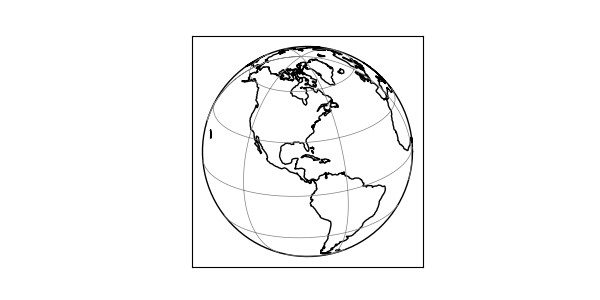

In [27]:
alt = np.inf
center_lon = -81*DEG2RAD
center_lat = 25*DEG2RAD
heading = 0*DEG2RAD

coords_near = mp.transform_perspective_near_side(coords, center_lat, center_lon, alt, heading, True)
grid_near = mp.transform_perspective_near_side(grid, center_lat, center_lon, alt, heading, False)

ax = mp.plot_line_map(coords_near, figsize=(6,3))
ax = mp.plot_line_map(grid_near, ax=ax, color="grey", linewidth=0.5)